# Verification plots

This is the same as `plot_avg_then_transform` except that the `spfh` and `spfh2m` fields are transformed to log space then averaged.

This seems suboptimal because there are grid-scale spiking values. They are hard to see in the plots, but note how much higher the colorbar is for the FVT 
`spfh` field.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import jax

from graphufs.datasets import Dataset
from graphufs.batchloader import BatchLoader

from graphufs.utils import get_last_input_mapping

from config import TP0Emulator
from baseline import P0Emulator

/home/tsmith/work/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [2]:
from weatherbench2.derived_variables import ZonalEnergySpectrum

In [3]:
fvt = TP0Emulator()

In [4]:
p0 = P0Emulator()

In [5]:
fvds = Dataset(fvt, mode="training")
pds = Dataset(p0, mode="training")

In [6]:
varlist = ["tmp", "spfh", "tmp2m", "spfh2m"]

### Snapshots

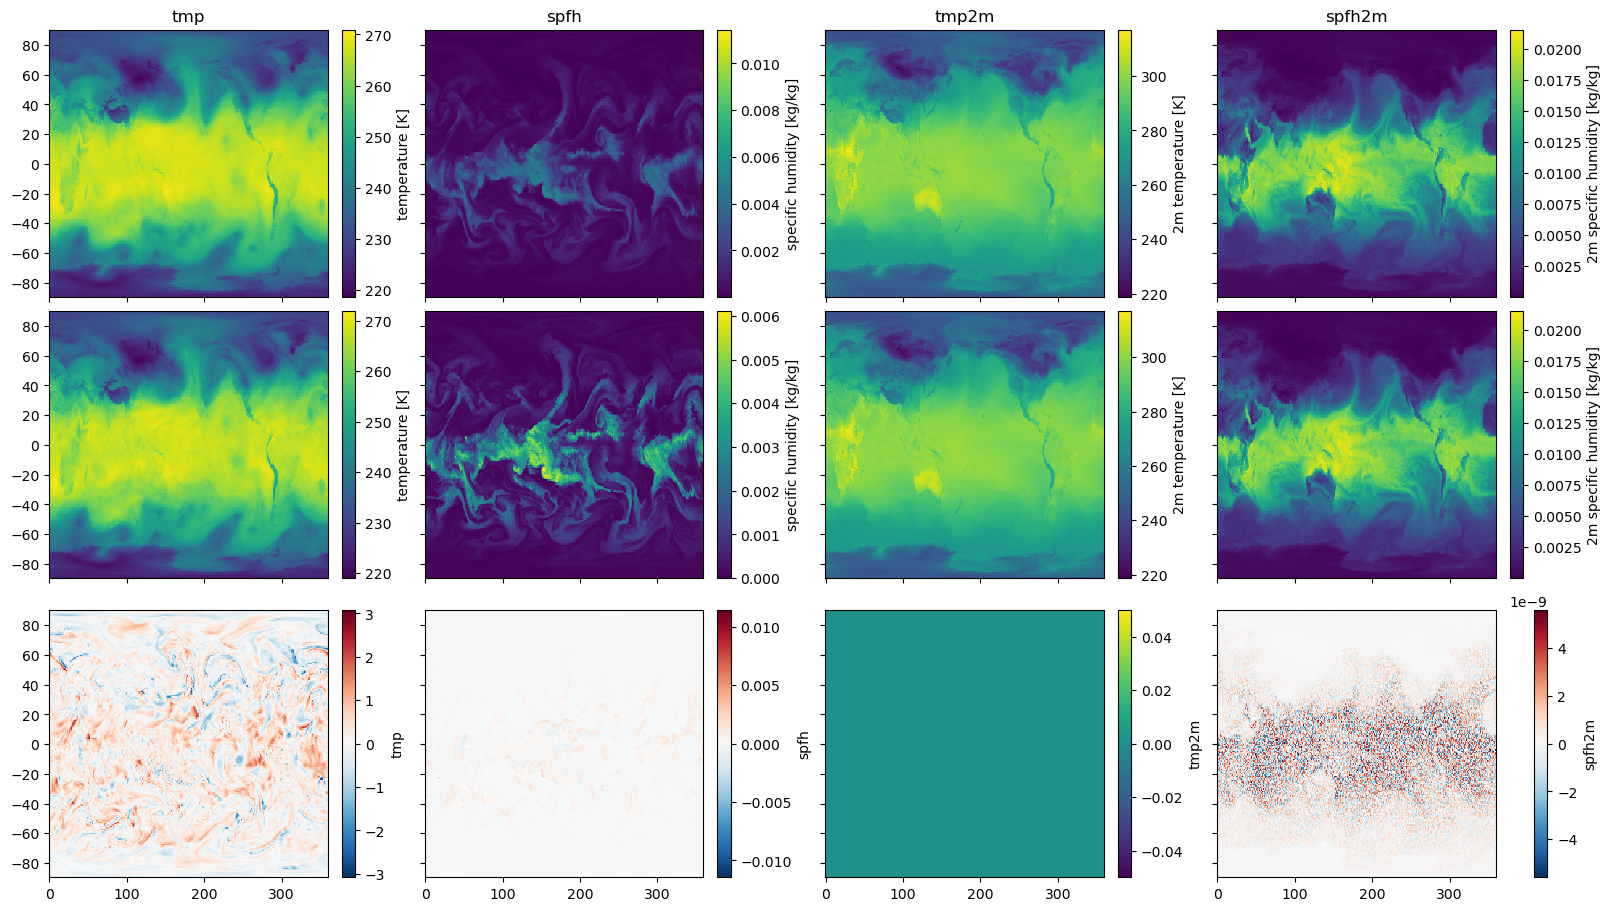

In [7]:
nrows = 3
ncols = len(varlist)
fig, axs = plt.subplots(nrows, len(varlist), figsize=(ncols*4, nrows*3), constrained_layout=True, sharex=True, sharey=True)

ilevel = 0
index = 10

plotlist = {k : list() for k in varlist}
for tds, axr in zip([fvds, pds], axs):
    xinputs, xtargets, xforcings = tds.get_xarrays(index)
    
    for v, ax in zip(varlist, axr):
        plotme = xtargets[v].squeeze()
        if "level" in plotme.dims:
            plotme = plotme.isel(level=ilevel, drop=True)

        transforms = tds.emulator.output_transforms
        if transforms is not None:
            if v in transforms:
                plotme = transforms[v](plotme)
        plotlist[v].append(plotme)
        plotme.plot(ax=ax)
        ax.set(
            xlabel="",
            ylabel="",
            title=v if ax.get_subplotspec().is_first_row() else "",
        )
for v, ax in zip(varlist, axs[-1]):
    diff = plotlist[v][1] - plotlist[v][0]
    diff.plot(ax=ax)
    ax.set(
        xlabel="",
        ylabel="",
        title="",
    )

* Top row: FVT
* middle row: baseline
* bottom row: FVT - baseline

### Spectra

[(0.00489331752836643, 100.0)]

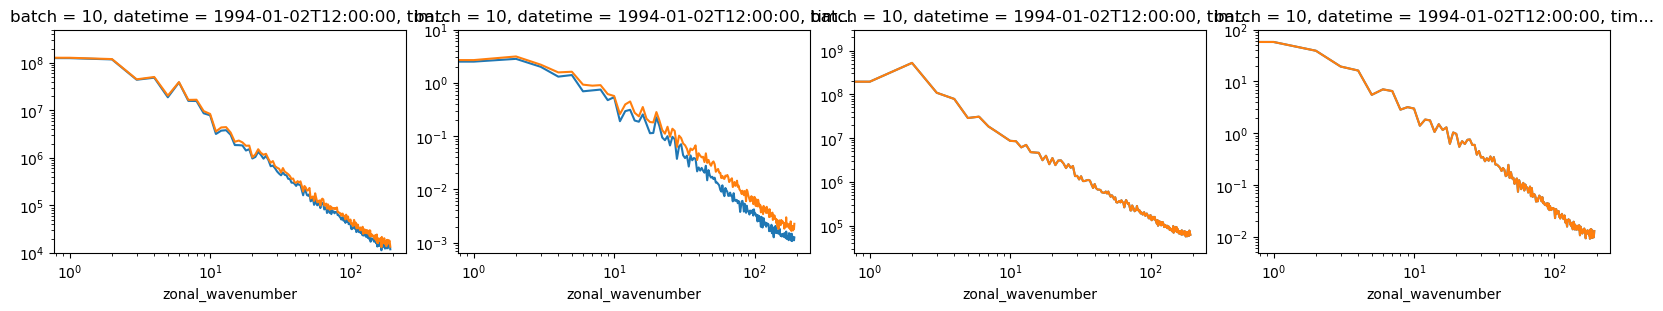

In [9]:
ncols = len(varlist)
fig, axs = plt.subplots(1, len(varlist), figsize=(ncols*4, 3), constrained_layout=True, sharex=True)

ilevel = 0
index = 10

plotlist = {k : list() for k in varlist}
for tds in [fvds, pds]:
    xinputs, xtargets, xforcings = tds.get_xarrays(index)
    
    for v, ax in zip(varlist, axs):
        computer = ZonalEnergySpectrum(v)
        plotme = xtargets[[v]].squeeze()
        plotme = plotme.rename({"lat": "latitude", "lon": "longitude"})
        if "level" in plotme.dims:
            plotme = plotme.isel(level=ilevel, drop=True)
        transforms = tds.emulator.output_transforms
        if transforms is not None:
            if v in transforms:
                plotme = transforms[v](plotme)

        plotme = plotme.compute()
        plotme = computer.compute(plotme)
        plotme = plotme.mean("latitude")
        plotlist[v].append(plotme)
        plotme.plot(ax=ax, xscale="log", yscale="log", x="zonal_wavenumber")
axs[0].set(ylim=(1e4, 5e8))
axs[1].set(ylim=(None, 1e1))
axs[2].set(ylim=(None, 3e9))
axs[3].set(ylim=(None, 1e2))